In [2]:
# Data
import yfinance as yf
import yahooquery

# Maths
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from scipy import stats
from statsmodels.tsa.stattools import coint

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Data handling
import pandas_datareader as pdr
import pandas_market_calendars as mcal

# Utility
import datetime

In [4]:
def Get_top_10_ETF_symbols(ETF):
    holdings = yahooquery.Ticker(ETF).fund_holding_info[ETF]['holdings']
    return [holding['symbol'] for holding in holdings]
def Get_ETF_data(ETF):
    tickers = Get_top_10_ETF_symbols(ETF)
    df = yf.download(tickers, start=valid_start_day)['Close']
    df = df.dropna(axis=0, how='any')
    return df

In [12]:
# Date and Time
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=1200)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

# List of ETF: https://en.wikipedia.org/wiki/List_of_American_exchange-traded_funds 

#SMH_top_10_tickers = Get_top_10_ETF_symbols('SMH') # VanEck Semiconductor ETF    #####Seems work#####
#AMLP_top_10_tickers = Get_top_10_ETF_symbols('AMLP') # energy, ALPS Alerian MLP ETF   #####Seems work#####
#VDE_top_10_tickers = Get_top_10_ETF_symbols('VDE') # Vanguard Energy  
#XLF_top_10_tickers = Get_top_10_ETF_symbols('XLF') # Financial Select Sector SPDR
#VOO_top_10_tickers = Get_top_10_ETF_symbols('VOO') # Vanguard S&P 500 ETF

# Download data
df = Get_ETF_data('SMH')

[*********************100%%**********************]  10 of 10 completed


In [14]:
df.tail(5)

Ticker,ADI,AMAT,AMD,ASML,AVGO,LRCX,NVDA,QCOM,TSM,TXN
Date,,,,,,,,,,
2024-12-31,212.460007,162.630005,120.790001,693.080017,231.839996,72.230003,134.289993,153.619995,197.490005,187.509995
2025-01-02,211.350006,163.869995,120.629997,700.419983,231.979996,72.440002,138.309998,153.639999,201.580002,186.949997
2025-01-03,215.369995,170.059998,125.370003,714.359985,232.550003,75.110001,144.470001,157.830002,208.610001,190.509995
2025-01-06,218.000000,177.479996,129.550003,768.510010,236.410004,77.980003,149.429993,159.850006,220.009995,192.179993
2025-01-07,215.869995,177.820007,127.330002,757.580017,228.639999,77.519997,140.139999,160.520004,211.419998,192.210007


In [16]:
# Split data
def Log_return(df): # We use log return as the time series instead of the stock itself (got more nicer properties!)
    return np.log(df/df.shift(1)).dropna()
TT_split = 0.8 #you need constant update so Train-test split must be large to see good result

Train_df = df[:int(len(df)*TT_split)]
Train_df_return = Log_return(Train_df)

Test_df = df[int(len(df)*TT_split):]

In [701]:
def find_cointegrated_pairs(df):
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2) # return: Test Statistic, P-value, Critical Values
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pair = {}
                pair['S1'],  pair['S2']= keys[i], keys[j]
                pairs.append(pair)
    return score_matrix, pvalue_matrix, pairs
    
def calculate_spread_zscore(pair, df, window):
    # Use log prices
    log_stock1 = np.log(df[pair['S1']])
    log_stock2 = np.log(df[pair['S2']])
    
    # Calculate hedge ratio using rolling OLS
    def calculate_hedge_ratio(y, x, window):
        rolling_beta = pd.Series(index=y.index)
        for i in range(window, len(y)):
            slope, _ = np.polyfit(x[i-window:i], y[i-window:i], 1)
            rolling_beta.iloc[i] = slope
        return rolling_beta

    hedge_ratio = calculate_hedge_ratio(log_stock1, log_stock2, window)
    
    spread = log_stock1 - hedge_ratio * log_stock2
    ma = spread.rolling(window=window, min_periods=window).mean()
    std = spread.rolling(window=window, min_periods=window).std()
    std = std.replace(0, np.nan)
    zscore = (spread - ma) / std
    return zscore

In [703]:
# Calculate rolling z
z_score_window = 20

# Find cointegrated pairs
score_matrix, pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(Train_df_return)

print(f"Found {len(cointegrated_pairs)} cointegrated pairs:")

Found 45 cointegrated pairs:


# Trading method
1) Trade at close
2) Long or Short a certine number of stocks every day based on mean reversion
3) z-entry and z-exit remain static
4) No cap on investment, just give the system however money it needs
5) Simple fixed feed: fix short fee (2%) and transaction cost
# Trading logic:
1) Get the z-entry and z-exit using past data
2) For each cointegrated pair, check:
   1) If not hold any position:
       1) If z-score > z-entry, Short the spread: Short S1 and Long S2
       2) If z-score < -1*z-entry, Long the spread: Long S1 Short S2
   2) If hold postion:
       1) If holding Short position and z-scores < z_exit, exit Short postion
       2) If holding Long position and z-score > -1*z-entry, exit Long positon 
3) Repeat this for a while and see what happen

In [727]:
def backtest(df, TT_split, pairs, z_score_window, z_entry, z_exit, initial_capital=10000, opt_mode=False):
    Train_len = int(len(df)*(TT_split))
    if opt_mode:
        df_test = df.iloc[:Train_len]
        Portfolio_value = pd.DataFrame(index=df.index[:Train_len])
        Test_position = pd.DataFrame().reindex_like(df[:Train_len])
    else:
        df_test = df.iloc[Train_len:]
        Portfolio_value = pd.DataFrame(index=df.index[Train_len:])
        Test_position = pd.DataFrame().reindex_like(df[Train_len:])
    Test_position[:] = 0
    Transaction_cost = 2  # USD per transaction
    base_annual_fee_rate = 0.02  # 2% annually
    borrow_fee_daily = base_annual_fee_rate / 252
    
    # Initialize cash tracking
    cash_track = pd.Series(0.0, index=Test_position.index)
    cash_track.iloc[0] = initial_capital
    share = 1  # Base unit for trading

    for i, pair in enumerate(pairs):
        zscores = calculate_spread_zscore(pair, df, z_score_window)[Train_len:]
        assert len(zscores) == len(df)-Train_len
        position = 0
        
        for j in range(len(zscores)):
            current_cash = cash_track.iloc[j]
            
            # Get current prices
            price1 = df_test[pair['S1']].iloc[j]
            price2 = df_test[pair['S2']].iloc[j]
            
            if position == 0:
                if zscores.iloc[j] > z_entry:  # Short the spread: Short S1 Long S2
                    position = -1
                    Test_position[pair['S1']].iloc[j] -= share  # Short S1 (gain cash)
                    Test_position[pair['S2']].iloc[j] += share  # Long S2 (spend cash)

                    cash_track.iloc[j] += price1*share - price2*share - price1*borrow_fee_daily*share
                        
                elif zscores.iloc[j] < -z_entry:  # Long the spread: Long S1 Short S2
                    position = 1
                    Test_position[pair['S1']].iloc[j] += share  # Long S1 (spend cash)
                    Test_position[pair['S2']].iloc[j] -= share  # Short S2 (gain cash)

                    cash_track.iloc[j] += -price1*share + price2*share - price2*borrow_fee_daily*share
                    
            elif position == -1:
                if zscores.iloc[j] < z_exit:  # Exit short position
                    position = 0
                    Test_position[pair['S1']].iloc[j] += share  # Buy back S1 (spend cash)
                    Test_position[pair['S2']].iloc[j] -= share  # Sell S2 (gain cash)

                    cash_track.iloc[j] += -price1*share + price2*share
                    
            elif position == 1:
                if zscores.iloc[j] > -z_exit:  # Exit long position
                    position = 0
                    Test_position[pair['S1']].iloc[j] -= share  # Sell S1 (gain cash)
                    Test_position[pair['S2']].iloc[j] += share  # Buy back S2 (spend cash)

                    cash_track.iloc[j] += price1*share - price2*share
    
    Test_position = Test_position.cumsum()
    keys = Test_position.keys()
    
    Portfolio_value[keys] = (Test_position[keys]*df_test[keys])
    Portfolio_value['stock worth'] = Portfolio_value[keys].sum(axis=1)
    Portfolio_value['cash'] = cash_track.cumsum() - len(Portfolio.columns)*Transaction_cost # We can do a single transaction for each stock instead of each pair
    
    Portfolio_value['Portfolio'] = Portfolio_value['cash'] + Portfolio_value['stock worth']

    if opt_mode:
        Portfolio_value['daily_return'] = Portfolio_value['Portfolio']/Portfolio_value['Portfolio'].shift(1)
        mean_return = Portfolio_value['daily_return'].dropna().mean()
        std_return = Portfolio_value['daily_return'].dropna().std()
        Ratio = mean_return/std_return
        return Ratio
    
    return Test_position, Portfolio_value

# Optimization:
1) Definition:
   1) Portfolio worth = cash + stocks worth(at close, could be negative based on long/short positions)
   2) Return = Portfolio_{t}/Portfolio_{t-1}
2) Optimize:
   2) Sharpe ratio = Return.mean()/Return.var()

I use differental evolution instead of simple gradiant decent since the opt surface might not be smooth enough in most cases

In [730]:
def optimize_zscore_params(df, TT_split, pairs, z_score_window):
    def objective(params):
        z_entry, z_exit = params
        
        if z_exit >= z_entry:  # Ensure logical constraint
            return 1e6  # Large penalty for z_entry > z_exit
        result = backtest(df, TT_split, pairs, z_score_window, z_entry, z_exit, opt_mode=True)
        if not np.isfinite(result):
            return 1e6  # Large penalty for NaN or inf results
        return -result  # Minimize negative Sortino ratio

    bounds = [(0.1, 3.0), (0.0, 2.0)]

    result = differential_evolution(
        objective,
        bounds,
        strategy='best1bin',
        maxiter=50,
        popsize=15,
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=None,
        callback=None,
        disp=False,
        polish=True,
        init='latinhypercube',
        updating='immediate',
        workers=1,
    )
    
    optimized_z_entry, optimized_z_exit = result.x

    return optimized_z_entry, optimized_z_exit


In [738]:
optimized_z_entry, optimized_z_exit = optimize_zscore_params(df, TT_split, cointegrated_pairs, z_score_window)
print(f'optimized z entry: {optimized_z_entry:.3f}')
print(f'optimized z exit: {optimized_z_exit:.3f}')

optimized z entry: 2.997
optimized z exit: 2.000


In [739]:
Position_book, Portfolio = backtest(df,TT_split,cointegrated_pairs,z_score_window,optimized_z_entry,optimized_z_exit)

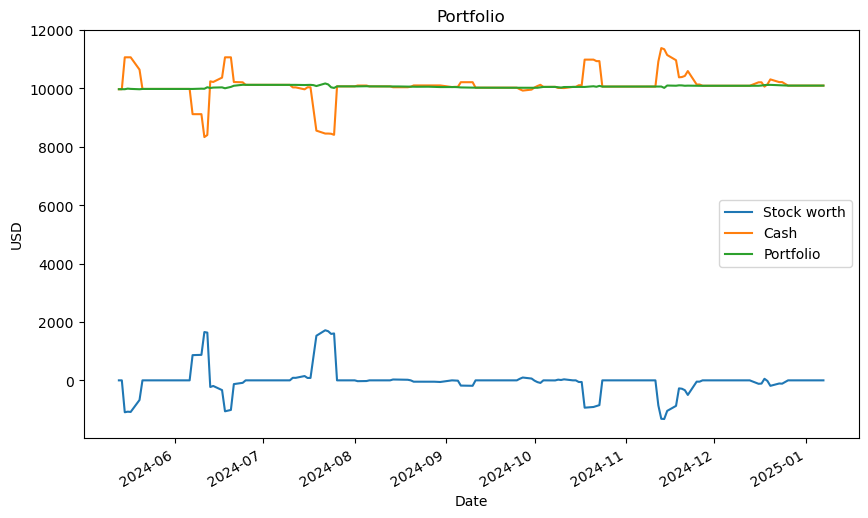

In [740]:
plt.figure(figsize=(10, 6))
Portfolio['stock worth'].plot(label="Stock worth")
Portfolio['cash'].plot(label="Cash")
Portfolio['Portfolio'].plot(ylabel='USD',title='Portfolio')
plt.legend()
plt.show()


In [741]:
print(f"lowest: {Portfolio['Portfolio'].min():.0f} USD")
print(f"highest: {Portfolio['Portfolio'].max():.0f} USD")

lowest: 9973 USD
highest: 10171 USD


<Axes: xlabel='Date', ylabel='Return'>

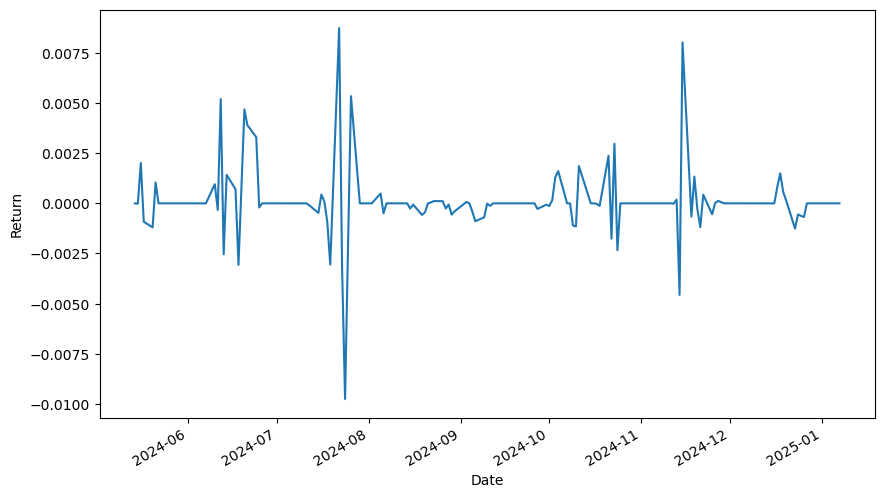

In [764]:
plt.figure(figsize=(10, 6))
Portfolio['Portfolio'].pct_change().plot(ylabel='Return')

In [760]:
Position_book

Ticker,ADI,AMAT,AMD,ASML,AVGO,LRCX,NVDA,QCOM,TSM,TXN
Date,,,,,,,,,,
2024-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-15,3.0,2.0,-1.0,-2.0,1.0,-3.0,0.0,0.0,0.0,0.0
2024-05-16,3.0,2.0,-1.0,-2.0,1.0,-3.0,0.0,0.0,0.0,0.0
2024-05-17,3.0,2.0,-1.0,-2.0,1.0,-3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
